In [2]:
import torch, torchvision
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from torch import nn
import pandas as pd
import numpy as np
from IPython.display import Image

In [3]:
def get_data():
    # Create training, validation and testing dataset objects
    training_data = torchvision.datasets.CIFAR10(
        root="/lus/eagle/projects/datasets/CIFAR-10/",
        train=True,
        download=False,
        transform=v2.Compose([
            v2.ToTensor(),
            v2.RandomHorizontalFlip(),
            v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)]))

    test_data = torchvision.datasets.CIFAR10(
        root="/lus/eagle/projects/datasets/CIFAR-10/",
        train=False,
        download=False,
        transform=torchvision.transforms.ToTensor()
    )

    training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

    batch_size = 128
    # The dataloader makes our dataset iterable 
    train_dataloader = torch.utils.data.DataLoader(training_data, 
        batch_size=batch_size, 
        pin_memory=True,
        shuffle=True, 
        num_workers=4)
    val_dataloader = torch.utils.data.DataLoader(validation_data, 
        batch_size=batch_size, 
        pin_memory=True,
        shuffle=False, 
        num_workers=4)

    # Create training and validation dataloader objects
    dev = torch.device(
        "cuda") if torch.cuda.is_available() else torch.device("cpu")


    def preprocess(x, y):
        # CIFAR-10 is *color* images so 3 layers!
        return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


    class WrappedDataLoader:
        def __init__(self, dl, func):
            self.dl = dl
            self.func = func

        def __len__(self):
            return len(self.dl)

        def __iter__(self):
            for b in self.dl:
                yield (self.func(*b))


    train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
    val_dataloader = WrappedDataLoader(val_dataloader, preprocess)
    return train_dataloader, val_dataloader

class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])
        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):
        return self.downsample(self.norm(inputs))
        
    
class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """
    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=2*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=2*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1)


    def forward(self, inputs):
        x = self.conv1(inputs)
        # The normalization layer:
        x = self.norm(x)
        x = self.conv2(x)
        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)
        x = self.conv3(x)
        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):

    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.
        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i in range(n_stages):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
                self.layers.append(nn.Dropout(0.1))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=4*current_n_filters,
                    shape = current_shape,
                    )
                )
                self.layers.append(nn.Dropout(0.1))
                # Double the number of filters:
                current_n_filters = 4*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x
        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    # loop over all of the batches
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        loss /= num_batches
        correct /= (size*dataloader.dl.batch_size)
        
        accuracy = 100*correct
        return accuracy, loss


def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()   
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()   

#### Create training, validation and testing dataset objects

In [2]:
train_dataloader, val_dataloader = get_data()

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [3]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#### Original Parameters

In [5]:
%%time
n_initial_filters = 64; n_stages = 4; blocks_per_stage = 2
model = Classifier(n_initial_filters, n_stages, blocks_per_stage)
model.to(dev)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
epochs = 30
cols = ["train_loss", "train_acc", "val_loss", "val_acc"]
training_frame = {col: [] for col in cols}
for j in range(epochs):
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    train_acc, train_loss = evaluate(train_dataloader, model, loss_fn) 
    print(f"Epoch {j}: train loss: {train_loss:.3f}, accuracy: {train_acc:.3f}" )
    val_acc, val_loss = evaluate(val_dataloader, model, loss_fn)
    print(f"Epoch {j}: validation loss: {val_loss:.3f}, accuracy: {val_acc:.3f}")
    training_frame["train_loss"].append(train_loss), training_frame["train_acc"].append(train_acc)
    training_frame["val_loss"].append(val_loss), training_frame["val_acc"].append(val_acc)

Epoch 0: train loss: 2.008, accuracy: 22.594
Epoch 0: validation loss: 1.999, accuracy: 22.656
Epoch 1: train loss: 1.570, accuracy: 41.823
Epoch 1: validation loss: 1.563, accuracy: 42.079
Epoch 2: train loss: 1.467, accuracy: 45.724
Epoch 2: validation loss: 1.472, accuracy: 45.421
Epoch 3: train loss: 1.265, accuracy: 54.246
Epoch 3: validation loss: 1.263, accuracy: 53.867
Epoch 4: train loss: 1.116, accuracy: 60.174
Epoch 4: validation loss: 1.132, accuracy: 58.396
Epoch 5: train loss: 1.020, accuracy: 63.623
Epoch 5: validation loss: 1.070, accuracy: 61.630
Epoch 6: train loss: 0.915, accuracy: 67.649
Epoch 6: validation loss: 0.964, accuracy: 65.180
Epoch 7: train loss: 0.867, accuracy: 69.434
Epoch 7: validation loss: 0.933, accuracy: 65.971
Epoch 8: train loss: 0.736, accuracy: 73.727
Epoch 8: validation loss: 0.815, accuracy: 70.055
Epoch 9: train loss: 0.744, accuracy: 73.572
Epoch 9: validation loss: 0.829, accuracy: 69.986
Epoch 10: train loss: 0.629, accuracy: 78.078
Epoc

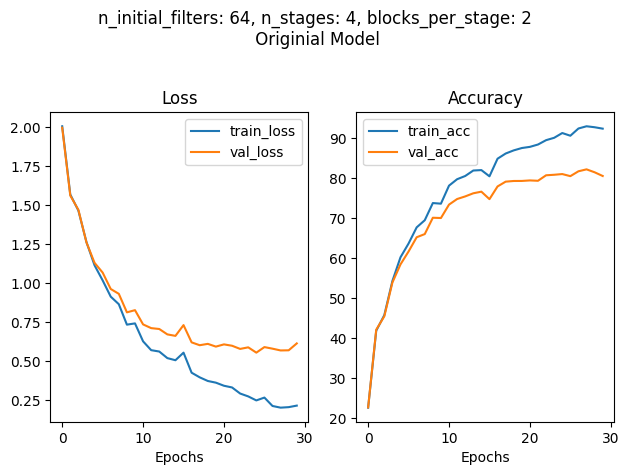

In [7]:
training_frame = pd.DataFrame(training_frame)
string = """These are the results of the original model. 
Clearly, the model is overfitting as the validation_accuracy has saturated at value much smaller than training_accuracy."""
fig, axs = plt.subplots(ncols=2)
title = f"n_initial_filters: {n_initial_filters}, n_stages: {n_stages}, blocks_per_stage: {blocks_per_stage}"
title += f"\n Originial Model\n"
# title += "\n conv_filter_size reduced to 7 -> 3, increased initial stride: 1 -> 2, added a lr scheduler\n"
plt.suptitle(title)
training_frame.plot(y=["train_loss", "val_loss"], ax=axs[0], xlabel='Epochs', title="Loss")
training_frame.plot(y=["train_acc", "val_acc"], ax=axs[1], xlabel='Epochs', title="Accuracy")
plt.tight_layout()
plt.show(fig)
plot = f'nif={n_initial_filters}_nstg={n_stages}_blks={blocks_per_stage}'
fig.savefig(f'{plot}.png')

To reduce overfitting, we reduce the num_parameters in the model by:
1.) Halving the intial_filters from 64 to 32
2.) Halving the number of stages from 4 to 2
Clearly, the model is still overfitting as the validation_accuracy has saturated at value smaller than training_accuracy.


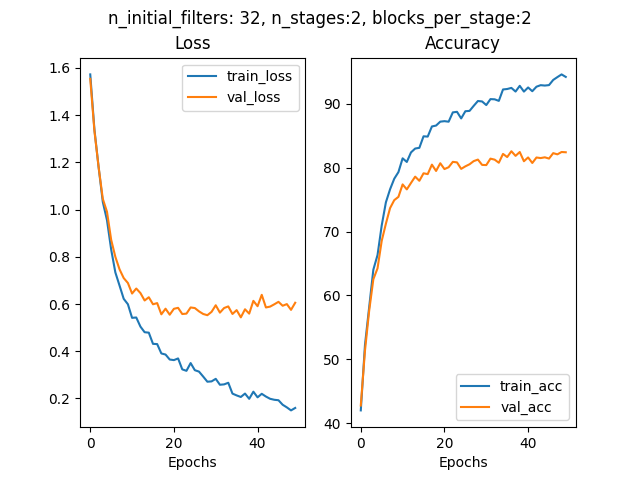

In [8]:
#num_initial_filers halved, num_stages halved
string = """To reduce overfitting, we reduce the num_parameters in the model by:
1.) Halving the intial_filters from 64 to 32
2.) Halving the number of stages from 4 to 2
Clearly, the model is still overfitting as the validation_accuracy has saturated at value smaller than training_accuracy."""
print(string)
Image("reduced_size_1.png")

We further decrease the model complexity by reducing the number of blocks per stage to 1.
Now, the training and validation accuracy are closer together, but we will have to train the model for more epochs, 
perhaps with a smaller learning rate to achieve good results.


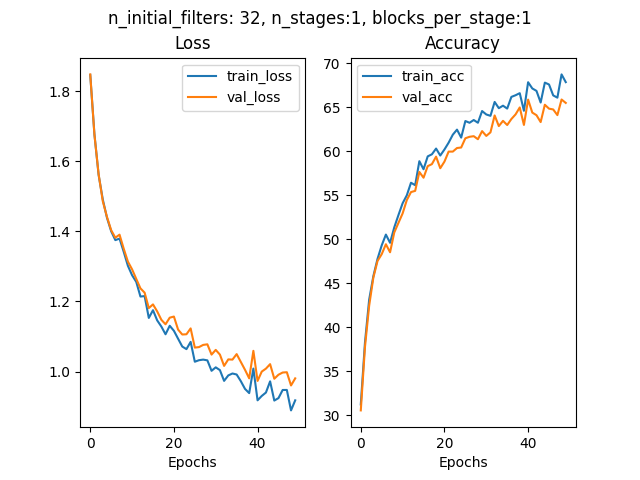

In [9]:
string = """We further decrease the model complexity by reducing the number of blocks per stage to 1.
Now, the training and validation accuracy are closer together, but we will have to train the model for more epochs, 
perhaps with a smaller learning rate to achieve good results."""
print(string)
Image("reduced_size_2.png")